# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Module 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging that the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what you could sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

### Import necessary libraries

In [1]:
import sqlite3
import pandas as pd
import json

import pymongo

import requests

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# conn = sqlite3.Connection('database.sqlite')
#'mongodb://127.0.0.1:27017/'


# API key
#7bfadd5c9ff1438d21931ef637ea414f
# lat = 52.520
# lon = 13.405

### Define classes

In [2]:
class WeatherGetter(object):
    
    def __init__(self):
        self.api_key = '7bfadd5c9ff1438d21931ef637ea414f'
        self.lat = '52.520'
        self.lon = '13.405'
        self.base_url = 'https://api.darksky.net/forecast'
        self.exclude = 'currently,flags,minutely,hourly,alerts'
  
    
    # Function to format date for url, taking datetime_string as input
    def format_datetime(self, datetime_string):
        year = datetime_string[:4]
        month = datetime_string[5:7]
        day = datetime_string[8:]
        
        return year, month, day
    
    # Function to build the url for an API call for a particular date
    def get_weather_for_date(self, datetime_string, verbose=True):
        
        year, month, day = self.format_datetime(datetime_string)
        
        datetime = "{}-{}-{}T12:00:00".format(year, month, day)
        full_url = "{}/{}/{},{},{}?exclude={}".format(self.base_url, self.api_key, 
                                                     self.lat, self.lon, 
                                                     datetime, self.exclude)
        # get response from server
        response = requests.get(full_url)
        if response.status_code == 200:
            if verbose:
                print(response.status_code)
            return response
        else: 
            raise ValueError("Error getting data from DarkSky API: Response Code {}".format(response.status_code))
        
        return response
    
    # Function to check if a (theoretical) day was rainy
    def rain_date(self, response, verbose=True):
        data = json.loads(response.text)
        daily = data['daily']
        data =  daily['data']
        data = data[0]
        if data['icon'] == 'rain':
            if verbose:
                print(data['icon'])
            return True
        else:
            if verbose:
                print(data['icon'])
            return False
    
    # Function to check if a **specific** day was rainy
    def rained_on_date(self, datetime_string):
        response = self.get_weather_for_date(datetime_string, verbose=False)
        did_it_rain = self.rain_date(response, verbose=False)
        
        return did_it_rain
    
    # Function that takes in a list of dates and returns a dictionary where k;v ~ date;True or False
    def get_weather_all_dates(self, date_list):
        
        rain_dict = {}
        for date in date_list:
            rain_dict[date] = self.rained_on_date(date)
            
        return rain_dict

In [22]:
class MongoHandler():
    
    def __init__(self):
        
        self.myclient = pymongo.MongoClient('mongodb://localhost:27017')
        self.db = self.myclient['german_soccer_lab_db']
        self.coll = self.db['german_soccer_lab_collection']
        
    def format_data(self, team_name, goals, wins, viz, rain_pct_won):
        
        data = {'team_name' : team_name,
                'goals' : goals,
                'wins' : wins,
                'W-L_barplot' : viz,
                'Pct_rainy_wins' : rain_pct_won
               }
        return data
        

    def insert_record(self, record):
        
        return self.coll.insert_one(data)

In [4]:
class SQLHandler(object):
    
    
    def __init__(self):
        self.dbname = 'database.sqlite'
        
    def connect_sql(self):
        
        conn = sqlite3.Connection(self.dbname)
        c = conn.cursor()
        
        return conn, c
    
    def create_df(self, query):
        
        df = pd.DataFrame(c.execute(query).fetchall())
        df.columns = [x[0] for x in c.description]
        
        return df

### Exploratory coding

In [5]:
sqlh = SQLHandler()
conn, c = sqlh.connect_sql()

query = """SELECT * FROM Teams;"""
teams_df = sqlh.create_df(query)

display(teams_df.head())
display(type(teams_df.Season[0]))

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


str

In [6]:
#pd.to_numeric(teams_df['Season'], errors='coerce')
teams_df['Season'] = teams_df['Season'].astype('int', copy=False)

In [7]:
# Just making sure Season is an int everywhere, for my peace of mind
teams_df.dtypes

Season                     int64
TeamName                  object
KaderHome                 object
AvgAgeHome                object
ForeignPlayersHome        object
OverallMarketValueHome    object
AvgMarketValueHome        object
StadiumCapacity           object
dtype: object

In [8]:
### TEAM NAMES ###
# Get all team names 

query_0 = """SELECT * FROM Matches WHERE Season == 2011;"""
full_matches_df = sqlh.create_df(query_0)
all_teams = full_matches_df['HomeTeam'].unique()
print(len(all_teams))

56


In [9]:
# Create a dictionary for each team to update with information we'll need later
team_data = {}
for team in all_teams:
    data = {'total_matches' : 0,
            'total_wins' : 0,
            'total_losses' : 0,
            'rain_wins' : 0,
            'rain_losses' : 0,
            'total_goals' : 0
           }
    team_data[team] = data

In [10]:
len(team_data)

56

In [11]:
team_data

{'Nurnberg': {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 'Stuttgart': {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 'Wolfsburg': {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 'Mainz': {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 'Freiburg': {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 "M'gladbach": {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 'Hamburg': {'total_matches': 0,
  'total_wins': 0,
  'total_losses': 0,
  'rain_wins': 0,
  'rain_losses': 0,
  'total_goals': 0},
 'Werder Bremen': {'total_matches': 0,
  'total_wins': 0,
  'total_lo

In [ ]:
#### TEAM NAMES ###
## Get team names 
#team_name_query = """SELECT DISTINCT AwayTeam AS Team_Name
#            FROM Matches
#            JOIN Teams_in_Matches
#            USING(Match_ID)
#            JOIN Unique_Teams
#            USING(Unique_Team_ID);"""
#teams_df = sqlh.create_df(team_name_query)

In [ ]:
#print(len(teams_df))
#print(teams_df.head(10))

In [ ]:
### 2011 Total Goals ###
#
#total_goals_2011_query = """SELECT DISTINCT Unique_Team_ID, Unique_Team, SUM(FTAG)+SUM(FTHG) AS Total_Goals
#                            FROM FlatView_Advanced
#                            WHERE Season == 2011
#                            GROUP BY Unique_Team_ID;"""
#
#total_goals_2011_df = sqlh.create_df(total_goals_2011_query)

In [ ]:
#total_goals_2011_df.head(10)

In [ ]:
### 2011 Total Wins ###
#
#total_wins_2011_query = """SELECT DISTINCT Unique_Team_ID, Unique_Team, COUNT(FTR) AS Total_Wins
#                            FROM FlatView_Advanced
#                            WHERE Season == 2011 AND ((FTR == 'H') OR (FTR == 'A'))
#                            GROUP BY Unique_Team_ID;"""
#
#total_wins_2011_df = sqlh.create_df(total_wins_2011_query)
#total_wins_2011_df

In [ ]:
### 2011 Total Wins ###
#
#total_wins_2011_query222 = """SELECT FTR 
#                            FROM FlatView_Advanced
#                            WHERE Unique_Team_ID == 24 AND Season == 2011
#                            ;"""
#
#total_wins_2011_df222 = sqlh.create_df(total_wins_2011_query222)
#total_wins_2011_df222
#total_wins_2011_df222['FTR'].value_counts() 

### Getting data from Dark Sky weather API

In [12]:
# Testing the weather getter
wg = WeatherGetter()
wg.rained_on_date('2011-01-04')

ValueError: Error getting data from DarkSky API: Response Code 403

In [13]:
# Get 2011 matches

matches_2011 = """SELECT * FROM Matches
                  WHERE Season == 2011;"""
matches_2011_df = sqlh.create_df(matches_2011)
matches_2011_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [14]:
# Remove duplicate dates before API call
unique_dates = matches_2011_df.Date.unique()
print(len(unique_dates))

165


In [15]:
# Make the API call and get the rain dates
rain_dates = wg.get_weather_all_dates(unique_dates)

ValueError: Error getting data from DarkSky API: Response Code 403

In [16]:
rain_dates

NameError: name 'rain_dates' is not defined

In [17]:
# Create a column for the dataframe 
rain_game = []
for date in matches_2011_df.Date:
    rain_game.append(rain_dates[date])
    
matches_2011_df['Rain_Game'] = rain_game    

NameError: name 'rain_dates' is not defined

In [42]:
# Update team information dictionary

def update_team_data(row):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    datetime = row['Date']
    year = datetime[:4]
    home_won = False
    away_won = False
    was_rain_game = row['Rain_Game']
    
    
    # Who won? Who lost?
    if row['FTR'] == 'H':
        home_won = True
        away_won = False
    elif row['FTR'] == 'A':
        home_won = False
        away_won = True
    else:
        home_won = False
        away_won = False
        
    # Update the record for the home team and away team, separately
    
    update_team_stats_record(home_team, home_goals, home_won, year, was_rain_game)
    update_team_stats_record(away_team, away_goals, away_won, year, was_rain_game)

# Define that function there ^^
    
def update_team_stats_record(team_name, goals, won, year, was_rain_game):
    
    team = team_data[team_name]
    team['total_matches'] = len(matches_2011_df[matches_2011_df.HomeTeam == team].FTR)

    if won == True:
        team['total_wins'] += 1
        if was_rain_game == True:
            team['rain_wins'] += 1
    else:
        team['total_losses'] += 1
        team['rain_losses'] += 1
    
    team['total_goals'] += goals

In [43]:
matches_2011_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


### Creating bar charts

In [20]:
# Apply functions supra to all records in the matches_2011_df

matches_2011_df.apply(update_team_data, axis=1)
print(team_data)

KeyError: ('Rain_Game', 'occurred at index 0')

### Bar plot

In [34]:
import numpy as np 
def get_barplot(team, show_viz=False):
    
    print('Team Total Wins: {}'.format(team['total_wins']))
    print('Team Total Losses: {}'.format(team['total_losses']))
    
    wins = team['total_wins']
    losses = team['total_losses']
        
    data = (wins, losses)
    y_pos = np.arange(len(data))
    plt.bar(y_pos, data)
    plt.xticks(y_pos, ('Wins', 'Losses'))
    plt.ylabel('Total Games')
    plt.title('Wins and Losses')

    
    viz = plt.show()
    
    if show_viz:
        plt.show()
        
    return viz    

plt.show()

Team Total Wins: 0
Team Total Losses: 0


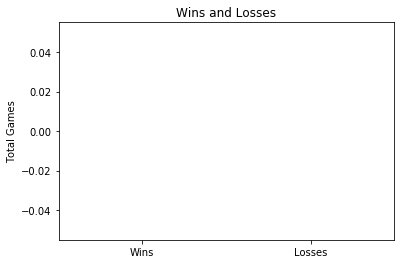

None


In [35]:
# Test out the graphing function
print(get_barplot(team_data['Tottenham']))

### Insert records into MongoDB

Team Total Wins: 0
Team Total Losses: 0


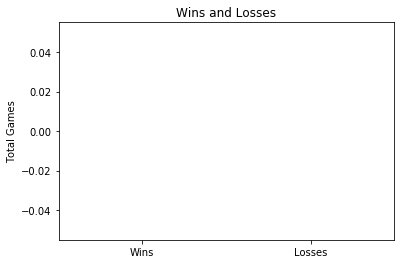

DuplicateKeyError: E11000 duplicate key error collection: german_soccer_lab_db.german_soccer_lab_collection index: _id_ dup key: { : ObjectId('5ce463c4e72a644e7a343884') }

In [31]:
# Create an instance of the MongoHandler class
db = MongoHandler()

for team_name, data in team_data.items():
    
    # Calculate the % of rainy wins for each team
    
    if (data['rain_wins'] == 0) and (data['rain_losses'] == 0):
        rain_pct_won = np.nan
    else:
        total_rain_games = data['rain_wins']+data['rain_losses']
        rain_pct_won = data['rain_wins']/total_rain_games
    
    # Get the bar chart
    viz = get_barplot(data)
    
    # Create the db record
    record = db.format_data(team_name, data['total_goals'], data['total_wins'], viz, rain_pct_won)
    
    # Insert the record into MongoDB
    db.insert_record(record)
    del(viz)

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!

In [48]:
# for team in team_names:
#
#    # Inner statement creates a new DF of Boolean values; used as an index to sort by team name; to retrieve all FTR/aka games played; then count them 
#    
#    totalMatches = len(matches_2011_df[matches_2011_df.HomeTeam == team].FTR)
#    totalWins = sum(matches_2011_df[matches_2011_df.HomeTeam == team]['FTR'] == 'H')
#    rainWins = sum((matches_2011_df[matches_2011_df.HomeTeam == team]['Rain_Game'] == True) and ((matches_2011_df[matches_2011_df.HomeTeam == team]["FTR"] == 'H') or (matches_2011_df[matches_2011_df.HomeTeam == team]["FTR"] == 'A')))
#    rainLoss = sum((matches_2011_df[matches_2011_df.HomeTeam == team]['Rain_Game'] == True) and (matches_2011_df[matches_2011_df.HomeTeam == team]["FTR"] == 'D'))
#    totalGoals = sum(matches_2011_df[matches_2011_df.HomeTeam == team]['FTHG'])